# CrowdWorks RAG System
* 식품개발팀 페르소나 기반
* Rag WorkFlow : https://flying-spinach-b72.notion.site/6-30-222853f7819580c0a092e22438a2dd5a?source=copy_link
* Mock DB(mock_databases.py) 세션 저장소에 업로드 필요



# 시스템 초기화 및 구성 요소 정의

## 기본 라이브러리 Import & API Key 설정

In [34]:
!pip install langgraph langchain langchain-openai pydantic
!pip install langchain-community python-dotenv
!pip install graphviz
!pip install tavily-python

In [35]:
import os
import time
import json
import asyncio
import random
from datetime import datetime
from typing import Dict, List, Any, Optional, Literal, AsyncGenerator
from enum import Enum
from pydantic import BaseModel, Field
from google.colab import userdata

# API 키 설정
try:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    print(">> OPENAI_API_KEY 설정 완료")
except:
    print(">> Colab Secrets에 'OPENAI_API_KEY' 추가 필요")

>> OPENAI_API_KEY 설정 완료


## 기본 데이터 모델 정의

In [36]:
class AgentType(str, Enum):
    """Agent Type 정의"""
    PLANNING = "planning" # 쿼리 분석 및 작업 플랜 수립
    RETRIEVER_X = "retriever_x" # Graph DB 중심의 관계 탐색 담당 검색 에이전트
    RETRIEVER_Y = "retriever_y" # Multi-source 검색 담당 (Vector, RDB, Web 등)
    CRITIC_1 = "critic_1" # 정보량 충분성 평가 담당
    CRITIC_2 = "critic_2" # 컨텍스트 품질 및 신뢰도 평가 담당
    CONTEXT_INTEGRATOR = "context_integrator" # 모든 검색 결과를 통합해 구조화된 문서 생성
    REPORT_GENERATOR = "report_generator" # 최종 보고서 및 사용자 응답 문서 생성
    SIMPLE_ANSWERER = "simple_answerer" # 단순 쿼리에 대해 빠른 응답 생성


class MessageType(str, Enum):
    """Agent 간 주고 받는 메세지 타입 정의"""
    REAL_TIME_HINT = "real_time_hint"
    SEARCH_REQUEST = "search_request"
    INTERESTING_FINDING = "interesting_finding"
    FEEDBACK = "feedback"
    RESULT = "result"
    # 코드 상에서 해당 메시지가 어떤 종류의 메시지 Type인지를 나타냄

class DatabaseType(str, Enum):
    """데이터베이스 타입"""
    GRAPH_DB = "graph_db"
    VECTOR_DB = "vector_db"
    RDB = "rdb"
    API = "api"
    WEB = "web"


class AgentMessage(BaseModel):
    """Agent 간 실시간 메시지"""
    from_agent: AgentType
    to_agent: AgentType
    message_type: MessageType
    content: str # 주요 텍스트 내용
    data: Dict[str, Any] = Field(default_factory=dict) # 부가 데이터(힌트, 키워드, 메타 정보, ...)
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())
    priority: int = Field(default=1, description="1=highest, 5=lowest")
    # 에이전트 간 데이터를 전달하는 구조 그 자체


class SearchResult(BaseModel):
    """검색 결과 표준 형태"""
    source: str # 데이터 소스 이름(graph_db, vector_db, ...)
    content: str # 검색 결과 내용
    relevance_score: float = Field(ge=0.0, le=1.0) # 검색 결과의 관련도
    metadata: Dict[str, Any] = Field(default_factory=dict)
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())
    search_query: str = "" # 검색한 쿼리 그 자체


class QueryPlan(BaseModel):
    """Planning Agent가 생성하는 쿼리 계획"""
    original_query: str
    sub_queries: List[str] = Field(default_factory=list)
    required_databases: List[DatabaseType] = Field(default_factory=list)
    priority: int = Field(default=1, ge=1, le=5)
    reasoning: str = "" # 현재 계획 수립 기준
    estimated_complexity: str = Field(default="medium")  # low, medium, high


class CriticResult(BaseModel):
    """Critic Agent의 평가 결과"""
    status: Literal["sufficient", "insufficient"]
    suggestion: str # 부족한 부분에 대한 보완 제안
    confidence: float # 신뢰도 점수
    reasoning: str # 충분/불충분에 대한 논리적 이유

## 실시간 피드백 채널

In [37]:
class RealTimeFeedbackChannel:
    """
    Agent 간 실시간 피드백 채널
    메모리 기반 큐(asyncio.Queue) 사용
    메시지를 비동기적으로 주고 받음
    """

    def __init__(self):
        self.x_to_y_queue = asyncio.Queue() # X -> Y
        self.y_to_x_queue = asyncio.Queue() # Y -> X
        self.active = asyncio.Event() # 채널 Active 여부
        self.active.set() # 초기 Actve 됨
        self.message_history: List[AgentMessage] = [] # 모든 송수신 메시지의 로그 기록

    async def send_x_to_y(self, message: AgentMessage):
        """X → Y 메시지 전송"""
        self.message_history.append(message)
        await self.x_to_y_queue.put(message)

    async def send_y_to_x(self, message: AgentMessage):
        """Y → X 메시지 전송"""
        self.message_history.append(message)
        await self.y_to_x_queue.put(message)

    async def get_messages_for_y(self) -> AsyncGenerator[AgentMessage, None]: # 실시간 스트리밍 지원
        """Y가 X로부터 받을 메시지들 스트리밍"""
        while self.active.is_set():
            try:
                message = await asyncio.wait_for(self.x_to_y_queue.get(), timeout=0.5)
                yield message
            except asyncio.TimeoutError:
                continue

    async def get_messages_for_x(self) -> AsyncGenerator[AgentMessage, None]:
        """X가 Y로부터 받을 메시지들 스트리밍"""
        while self.active.is_set():
            try:
                message = await asyncio.wait_for(self.y_to_x_queue.get(), timeout=0.5)
                yield message
            except asyncio.TimeoutError:
                continue

    def stop(self):
        """채널 종료"""
        self.active.clear()

    def get_message_count(self) -> Dict[str, int]:
        """메시지 통계"""
        x_to_y = sum(1 for msg in self.message_history if msg.from_agent == AgentType.RETRIEVER_X)
        y_to_x = sum(1 for msg in self.message_history if msg.from_agent == AgentType.RETRIEVER_Y)
        return {"x_to_y": x_to_y, "y_to_x": y_to_x, "total": len(self.message_history)}


## 개별 Agent Memory 설정

In [38]:
class AgentMemory(BaseModel):
    """각 Agent의 개별 메모리"""
    agent_type: AgentType
    internal_state: Dict[str, Any] = Field(default_factory=dict) # 임시 변수나 상태 저장용
    message_history: List[AgentMessage] = Field(default_factory=list)
    findings: List[str] = Field(default_factory=list) # 에이전트가 과정 중 발견한 주요 인사이트/패턴/의미 있는 로그
    performance_metrics: Dict[str, float] = Field(default_factory=dict) # 성능 지표 (검색 속도, 중복 제거 비율, 응답 성공률, ...)

    def add_finding(self, finding: str):
        """새로운 발견 추가"""
        self.findings.append(f"[{datetime.now().strftime('%H:%M:%S')}] {finding}")

    def update_metric(self, metric_name: str, value: float):
        """성능 지표 업데이트"""
        self.performance_metrics[metric_name] = value


## 메인 State 정의


In [39]:
class StreamingAgentState(BaseModel):
    """실시간 스트리밍 Multi-Agent 상태"""

    # 메인 정보
    original_query: str
    current_iteration: int = Field(default=0, ge=0) # 현재 반복 횟수
    max_iterations: int = Field(default=2, ge=1, le=5) # 최대 반복 횟수
    start_time: str = Field(default_factory=lambda: datetime.now().isoformat()) # 세션 시작 시간(질의 처리 소요 시간)

    # Planning 결과
    query_plan: Optional[QueryPlan] = None
    planning_complete: bool = False

    # 실시간 검색 결과 스트림
    graph_results_stream: List[SearchResult] = Field(default_factory=list)
    multi_source_results_stream: List[SearchResult] = Field(default_factory=list)

    # --- 여기에 아래 두 필드를 추가해주세요 ---
    # Retriever X가 추출한 힌트 (Retriever Y가 참조할 수 있도록)
    x_extracted_hints: List[Dict] = Field(default_factory=list)
    # Retriever Y가 제안한 추가 검색 키워드 (Critic이나 Planning Agent가 참조할 수 있도록)
    y_suggested_keywords: List[str] = Field(default_factory=list)
    # --- 여기까지 추가해주세요 ---

    # Retriever 활성 상태
    x_active: bool = False
    y_active: bool = False
    search_complete: bool = False

    # Agent 메모리
    agent_memories: Dict[str, AgentMemory] = Field(default_factory=dict)

    # Critic 평가 결과
    critic1_result: Optional[CriticResult] = None
    critic2_result: Optional[CriticResult] = None
    info_sufficient: bool = False
    context_sufficient: bool = False

    # 통합 및 최종 생성 결과
    integrated_context: str = ""
    final_answer: str = ""

    # 성능 및 통계
    total_search_results: int = 0
    total_messages_exchanged: int = 0
    processing_time_seconds: float = 0.0

    class Config:
        arbitrary_types_allowed = True # 비정형 객체 허용 설정

    def __init__(self, **data):
        super().__init__(**data)
        # Agent 메모리 초기화(모든 Agent에 대해 AgentMemory를 생성)
        for agent_type in AgentType:
            agent_key = agent_type.value
            if agent_key not in self.agent_memories:
                self.agent_memories[agent_key] = AgentMemory(agent_type=agent_type)

    def get_agent_memory(self, agent_type: AgentType) -> AgentMemory:
        """특정 Agent 메모리 반환"""
        return self.agent_memories[agent_type.value]

    def add_graph_result(self, result: SearchResult):
        """Graph 검색 결과 추가"""
        self.graph_results_stream.append(result)
        self.total_search_results += 1

    def add_multi_source_result(self, result: SearchResult):
        """Multi-source 검색 결과 추가"""
        self.multi_source_results_stream.append(result)
        self.total_search_results += 1

    def get_all_results(self) -> List[SearchResult]: # 현재는 사용 안함(Context integrator에서 사용 가능)
        """모든 검색 결과 반환"""
        return self.graph_results_stream + self.multi_source_results_stream

    def get_latest_results(self, limit: int = 10) -> List[SearchResult]: # 현재는 사용 안함
        """최신 검색 결과 반환"""
        all_results = self.get_all_results()
        sorted_results = sorted(all_results, key=lambda x: x.timestamp, reverse=True)
        return sorted_results[:limit]

    def get_performance_summary(self) -> Dict[str, Any]: # 평가 필요시 사용
        """성능 요약 반환"""
        return {
            "total_iterations": self.current_iteration,
            "total_search_results": self.total_search_results,
            "graph_results": len(self.graph_results_stream),
            "multi_source_results": len(self.multi_source_results_stream),
            "messages_exchanged": self.total_messages_exchanged,
            "processing_time": self.processing_time_seconds,
            "info_sufficient": self.info_sufficient,
            "context_sufficient": self.context_sufficient,
            "planning_complete": self.planning_complete
        }

    def reset_for_new_iteration(self): # Critic에서 정보 불충분으로 인해 새로운 반복이 진행될 때 이전 정보를 리셋
        """새 반복을 위한 상태 리셋"""
        self.x_active = False
        self.y_active = False
        self.search_complete = False
        self.current_iteration += 1

    def should_terminate(self) -> bool:
        """최대 반복 도달 여부"""
        return self.current_iteration >= self.max_iterations


## 헬퍼 함수

In [40]:
def create_agent_message(
    from_agent: AgentType,
    to_agent: AgentType,
    message_type: MessageType,
    content: str,
    data: Dict[str, Any] = None,
    priority: int = 1
) -> AgentMessage: # RetrieverAgentWithFeedback에서 피드백 전송시 사용

    """Agent 메시지 생성 헬퍼"""
    return AgentMessage(
        from_agent=from_agent,
        to_agent=to_agent,
        message_type=message_type,
        content=content,
        data=data or {},
        priority=priority
    )

def create_search_result(
    source: str,
    content: str,
    relevance_score: float,
    metadata: Dict[str, Any] = None,
    search_query: str = ""
) -> SearchResult: # DB 검색 결과를 Search Result로 포맷팅
    """검색 결과 생성 헬퍼"""
    return SearchResult(
        source=source,
        content=content,
        relevance_score=relevance_score,
        metadata=metadata or {},
        search_query=search_query
    )

def create_critic_result(
    status: Literal["sufficient", "insufficient"],
    suggestions: str,
    confidence: float,
    reasoning: str,
    improvement_areas: List[str] = None
) -> CriticResult:
    """Critic 결과 생성 헬퍼"""
    return CriticResult(
        status=status,
        suggestions=suggestions,
        confidence=confidence,
        reasoning=reasoning,
        improvement_areas=improvement_areas or []
    )

def create_query_plan(
    original_query: str,
    sub_queries: List[str],
    required_databases: List[DatabaseType],
    reasoning: str = "",
    priority: int = 1,
    estimated_complexity: str = "medium"
) -> QueryPlan: # Planning Agent의 Plan 생성
    """쿼리 계획 생성 헬퍼"""
    return QueryPlan(
        original_query=original_query,
        sub_queries=sub_queries,
        required_databases=required_databases,
        reasoning=reasoning,
        priority=priority,
        estimated_complexity=estimated_complexity
    )

# 초기 상태 생성 함수
def create_initial_state(query: str, max_iterations: int = 3) -> tuple[StreamingAgentState, RealTimeFeedbackChannel]:
    """초기 상태 + 피드백 채널 생성"""
    state = StreamingAgentState(
        original_query=query,
        max_iterations=max_iterations
    ) # Workflow 실행 시 & Test 함수 실행 시 State, Feedback Channel 초기화

    # 피드백 채널 별도 생성
    feedback_channel = RealTimeFeedbackChannel()

    print(f"- 초기 상태 생성 완료")
    print(f"- 쿼리: {query}")
    print(f"- 최대 반복: {max_iterations}")
    print(f"- 피드백 채널: 활성화")

    return state, feedback_channel

def validate_state(state: StreamingAgentState) -> bool: # State가 정상적으로 생성됐는지 여부를 검증
    """상태 유효성 검증"""
    try:
        # 기본 필드 검증
        assert state.original_query, "원본 쿼리가 비어있음" # 값이 없으면 오류 메시지 "원본 쿼리가 비어있음" 반환
        assert 0 <= state.current_iteration <= state.max_iterations, "반복 횟수 범위 오류"

        # Agent 메모리 검증
        assert len(state.agent_memories) == len(AgentType), "Agent 메모리 개수 불일치"

        print(f"- 상태 검증 통과")
        return True

    except AssertionError as e:
        print(f"\n>> 상태 검증 실패: {e}")
        return False
    except Exception as e:
        print(f"\n>> 상태 검증 오류: {e}")
        return False


# Pydantic 모델 테스트용 샘플 데이터 생성
def create_sample_data():
    """테스트용 샘플 데이터"""

    # 샘플 쿼리 계획
    sample_plan = create_query_plan(
        original_query="쌀 가격 상승 원인 분석",
        sub_queries=[
            "쌀 가격 상승 현황은?",
            "주요 원인 요소들은?",
            "향후 전망은?"
        ],
        required_databases=[DatabaseType.GRAPH_DB, DatabaseType.RDB, DatabaseType.WEB],
        reasoning="다각도 분석을 위해 그래프, 정형데이터, 웹 정보 필요"
    )

    # 샘플 검색 결과
    sample_result = create_search_result(
        source="graph_db",
        content="쌀-가격상승-기후요인 관계 발견",
        relevance_score=0.85,
        metadata={"entity": "쌀", "relations": ["가격상승", "기후요인"]},
        search_query="쌀 가격 관계"
    )

    # 샘플 메시지
    sample_message = create_agent_message(
        from_agent=AgentType.RETRIEVER_X,
        to_agent=AgentType.RETRIEVER_Y,
        message_type=MessageType.REAL_TIME_HINT,
        content="쌀-기후요인 관계 발견, 관련 최신 데이터 검색 필요",
        data={"entities": ["쌀", "기후요인"], "priority": "high"}
    )

    return {
        "query_plan": sample_plan,
        "search_result": sample_result,
        "agent_message": sample_message
    }

## Pydantic Model Test

In [41]:
# Pydantic Model Test : 전체 시스템에서 사용하는 Pydantic 모델(AgentMessage, SearchResult, QueryPlan, ...) 정상 작동 검증
def test_pydantic_models():
    """Pydantic 모델 테스트"""
    print(">>> Pydantic 모델 테스트 시작...")

    try:
        # 샘플 데이터 생성
        samples = create_sample_data()
        print("- 샘플 데이터 생성 성공")

        # 초기 상태 + 피드백 채널 생성
        state, feedback_channel = create_initial_state("테스트 쿼리") # original_query == "테스트 쿼리"
        print("- 초기 상태 + 피드백 채널 생성 성공")

        # 상태에 샘플 데이터 추가
        state.query_plan = samples["query_plan"]
        state.add_graph_result(samples["search_result"])
        print("- 상태 업데이트 성공")

        # 피드백 채널 테스트
        message_stats = feedback_channel.get_message_count()
        print(f"- 피드백 채널 통계: {message_stats}")

        # 상태 검증
        validate_state(state)

        # 성능 요약 테스트
        summary = state.get_performance_summary()
        print(f"- 성능 요약: {summary}")

        # 피드백 채널 정리
        feedback_channel.stop()
        print("- 피드백 채널 정리 완료")

        print("\n>>> 모든 Pydantic 모델 테스트 통과")
        return True

    except Exception as e:
        print(f"\n>>> 테스트 실패: {e}")
        import traceback
        traceback.print_exc()
        return False

# 실행
test_result = test_pydantic_models()
print(f"\n최종 결과: {'성공' if test_result else '실패'}")

>>> Pydantic 모델 테스트 시작...
- 샘플 데이터 생성 성공
- 초기 상태 생성 완료
- 쿼리: 테스트 쿼리
- 최대 반복: 3
- 피드백 채널: 활성화
- 초기 상태 + 피드백 채널 생성 성공
- 상태 업데이트 성공
- 피드백 채널 통계: {'x_to_y': 0, 'y_to_x': 0, 'total': 0}
- 상태 검증 통과
- 성능 요약: {'total_iterations': 0, 'total_search_results': 1, 'graph_results': 1, 'multi_source_results': 0, 'messages_exchanged': 0, 'processing_time': 0.0, 'info_sufficient': False, 'context_sufficient': False, 'planning_complete': False}
- 피드백 채널 정리 완료

>>> 모든 Pydantic 모델 테스트 통과

최종 결과: 성공


## Feedback Channel Test

In [42]:
# Feedback Channel Test
async def test_feedback_channel():
    """피드백 채널 비동기 테스트"""
    print(">>> 피드백 채널 비동기 테스트 시작...")

    try:
        # 상태 및 채널 생성
        state, channel = create_initial_state("비동기 테스트")

        # 테스트 메시지 생성
        test_message = create_agent_message(
            from_agent=AgentType.RETRIEVER_X,
            to_agent=AgentType.RETRIEVER_Y,
            message_type=MessageType.REAL_TIME_HINT,
            content="테스트 힌트 메시지"
        )

        # 메시지 전송
        await channel.send_x_to_y(test_message)
        print("- 메시지 전송 성공")

        # 메시지 수신 테스트
        received_count = 0
        async for message in channel.get_messages_for_y():
            print(f"- 수신: {message.content}")
            received_count += 1
            if received_count >= 1:  # 일단 1개만 받고 중단
                break

        print("- 메시지 수신 성공")

        # 통계 확인
        stats = channel.get_message_count()
        print(f"- 메시지 통계: {stats}")

        # 채널 정리
        channel.stop()
        print("- 채널 정리 완료")

        print(">>> 피드백 채널 비동기 테스트 완료")
        return True

    except Exception as e:
        print(f"\n>> 비동기 테스트 실패: {e}")
        return False

# 비동기 테스트 실행
async_result = await test_feedback_channel()
print(f"\n>>> 비동기 테스트 결과: {'성공' if async_result else '실패'}")

>>> 피드백 채널 비동기 테스트 시작...
- 초기 상태 생성 완료
- 쿼리: 비동기 테스트
- 최대 반복: 3
- 피드백 채널: 활성화
- 메시지 전송 성공
- 수신: 테스트 힌트 메시지
- 메시지 수신 성공
- 메시지 통계: {'x_to_y': 1, 'y_to_x': 0, 'total': 1}
- 채널 정리 완료
>>> 피드백 채널 비동기 테스트 완료

>>> 비동기 테스트 결과: 성공


## Mock DB Import & DB 모델 구조

In [43]:
from mock_databases import MockGraphDB, MockVectorDB, MockRDB, MockWebSearch, create_mock_databases

# 데이터베이스들 생성
graph_db, vector_db, rdb, web_search = create_mock_databases()

# 디버깅 코드
# print(">> Mock Database 로드 완료")
# result = graph_db.search("완두콩")
# print(">> Graph DB 검색 결과")
# print(result)

>> Enhanced Eco-Trend Mock Databases 초기화 시작
>> Mock Graph DB 초기화 시작
- Enhanced Mock Graph DB 초기화 완료
>> Enhanced Mock Vector DB 초기화 시작
- Enhanced Mock Vector DB 초기화 완료
>> Enhanced Mock RDB 초기화 시작
- Enhanced Mock RDB 초기화 완료
>> Enhanced Mock Web Search 초기화 시작
- Enhanced Mock Web Search 초기화 완료
======= Enhanced Eco-Trend Mock Databases 초기화 완료 =======
Graph DB: 68개 노드 (친환경 트렌드 식재료 대폭 추가)
Vector DB: 13개 문서 (친환경 연구자료 풍부)
RDB: 6개 테이블 (가격, 영양, 시장, 소비자트렌드, 인증, 신제품개발)
Web Search: 11개 카테고리 (친환경 뉴스 대폭 확장)


### MockGraphDB

* Node
```
{
  "id": "ingredient_pea",
  "labels": ["Ingredient"],
  "properties": {
    "name": "완두콩",
    "english_name": "pea",
    "category": "legume",
    "protein_rich": true
  }
}
```

* Relationship
```
{
  "id": "rel_001",
  "type": "HAS_PRICE",
  "start_node": "ingredient_pea",
  "end_node": "price_pea_2024",
  "properties": {
    "market_stability": "stable"
  }
}
```

### MockVectorDB

* 기본 구조
```
{
  "id": "doc_001",
  "title": "완두콩 단백질 시장 2025년 1000억 돌파 전망",
  "content": "국내 완두콩 기반 식물성 단백질 시장이 급성장하며...",
  "metadata": {
    "source": "농민신문",
    "category": "시장분석",
    "reliability": 0.92
  },
  "similarity_score": 0.95
}
```

### MockRDB

* 가격 정보
```
{
  "item": "완두콩",
  "date": "2024-03-15",
  "region": "서울",
  "market": "가락시장",
  "avg_price": 1250,
  "unit": "원/kg",
  "grade": "상품",
  "supply_volume": 450,
  "price_change": "+3.2%"
}
```

* 영양 정보
```
{
  "item": "퀴노아",
  "serving_size": "100g",
  "calories": 368,
  "protein": 14.1,
  "fat": 6.1,
  "carbohydrate": 64.2,
  "fiber": 7.0
}
```

* 시장 데이터
```
{
  "category": "식물성 단백질",
  "year": 2024,
  "market_size_billion_won": 850,
  "growth_rate": "18.5%",
  "forecast_2025_billion_won": 1008,
  "key_players": ["CJ제일제당", "대상", "삼양사"]
}
```

### MockWebSearch

* 뉴스 기사
```
{
  "title": "퀴노아, K-푸드 열풍과 함께 급부상",
  "url": "https://www.kfoodnews.com/trend789",
  "snippet": "퀴노아가 K-푸드 트렌드와 함께 국내 건강식품 시장에서 급부상...",
  "published_date": "2024-03-19",
  "relevance": 0.92
}
```

* 트랜드 데이터
```
{
  "trend": "식물성 대체육",
  "growth_rate": "25%",
  "market_size": "500억원",
  "key_factors": ["환경의식", "건강관심", "동물복지"]
}
```

### 전체 요약 테이블

| DB 유형      | 데이터 모델                             | 주요 함수   | 반환 결과                             |
|---------------|-----------------------------------------|-------------|----------------------------------------|
| **GraphDB**   | Node + Relationship                    | `search()`  | nodes + relationships                 |
| **VectorDB**  | 문서 (title, content, metadata, score) | `search()`  | 유사 문서 리스트                      |
| **RDB**       | 가격, 영양, 시장 테이블                | `search()`  | prices, nutrition, market_data        |
| **WebSearch** | 기사 + 트렌드                          | `search()`  | 기사 리스트 + 시장 트렌드             |

# Multi-Agent

## Multi-Agent Core Import

In [44]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END

## Planning Agent

In [45]:
class PlanningAgent:
    def __init__(self):
        # 단순 판단, 전략 생성/평가에는 비용 효율적인 모델 사용
        self.chat = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        self.agent_type = AgentType.PLANNING

    async def plan(self, state: StreamingAgentState) -> StreamingAgentState:
        print(">> PLANNING 단계 시작 (ToT 적용)")
        query = state.original_query
        print(f"- 원본 쿼리: {query}")

        complexity = await self._judge_complexity(query)
        print(f"- 복잡도 판단: {complexity}")

        if complexity == "simple":
            state.query_plan = QueryPlan(
                original_query=query,
                sub_queries=[query],
                estimated_complexity="low"
            )
        else:
            # ToT 적용
            # 여러 검색 전략 생성
            search_strategies = await self._decompose_query_into_strategies(query)
            print(f"\\n>> 생성된 검색 전략(ToT): {search_strategies}")

            # 최적 전략 선택
            best_strategy = await self._select_best_strategy(query, search_strategies)
            print(f"- 선택된 최적 전략: {best_strategy}")

            # 선택된 전략을 sub_queries로 설정
            state.query_plan = QueryPlan(
                original_query=query,
                sub_queries=[best_strategy], # 가장 유망한 전략 하나만 전달
                estimated_complexity="high"
            )

        state.planning_complete = True
        print(">> PLANNING 단계 완료")
        return state

    async def _judge_complexity(self, query: str) -> str:
        complex_keywords = ["오늘", "실시간", "현재", "최신", "분석", "비교", "예측", "전망", "영향"]

        if any(keyword in query for keyword in complex_keywords):
            return "complex"

        prompt = f"""사용자 질문의 복잡도를 평가하여 'simple' 또는 'complex' 둘 중 하나로만 답변하세요.
        - simple: 간단한 인사, 정의, 단순 사실 질문
        - complex: 분석, 예측, 비교 등 여러 단계의 추론이나 도구 사용이 필요한 모든 질문
        질문: "{query}"
        답변 (simple/complex):"""

        response = await self.chat.ainvoke(prompt)
        return "simple" if "simple" in response.content.lower() else "complex"


    async def _decompose_query_into_strategies(self, query: str) -> list:
        """질문을 2~3개의 다른 관점의 검색 전략으로 분해"""
        prompt = f"""
        당신은 복잡한 질문을 해결하기 위한 '다양한 검색 전략'을 2~3개 생성하는 전략가입니다.
        각 전략은 ReAct 에이전트가 수행할 구체적인 질문 형태여야 합니다.

        <원본 질문>
        {query}
        </원본 질문>

        <검색 전략 목록> (각 전략은 한 줄로 작성)
        """
        response = await self.chat.ainvoke(prompt)
        return [line.strip() for line in response.content.split('\n') if line.strip()]


    async def _select_best_strategy(self, original_query: str, strategies: list) -> str:
        """생성된 여러 검색 전략 중 가장 유망한 전략 하나를 선택"""

        if not strategies:
            return original_query
        if len(strategies) == 1:
            return strategies[0]

        strategies_text = "\\n".join([f"- {s}" for s in strategies])
        prompt = f"""
        당신은 여러 검색 전략 중 가장 효율적이고 질문의 의도에 부합하는 것을 선택하는 전문가입니다.
        아래 <검색 전략 목록> 중에서 <원본 질문>에 대한 답을 찾기에 가장 좋은 전략 하나만 선택하고, 다른 설명 없이 해당 전략의 내용만 정확히 반환해주세요.

        <원본 질문>
        {original_query}

        <검색 전략 목록>
        {strategies_text}

        <최고의 전략>
        """
        response = await self.chat.ainvoke(prompt)
        return response.content.strip()

### Planning Agent Test

In [46]:
async def test_planning_agent():
    print(">> Planning Agent 테스트")

    planning_agent = PlanningAgent()

    test_queries = [
        "쌀의 영양성분은?",  # SIMPLE
        "안녕",
        "완두콩 가격 상승 원인 분석하고 시장 전망 제시해줘"  # COMPLEX
    ]

    for query in test_queries:
        print(f"\n>> 테스트 쿼리: {query}")
        print("="*50)

        state, _ = create_initial_state(query)
        result_state = await planning_agent.plan(state)

        print(f"- 복잡도: {result_state.query_plan.estimated_complexity}")
        print(f"- 세부 쿼리들: {result_state.query_plan.sub_queries}")

# 실행
await test_planning_agent()

>> Planning Agent 테스트

>> 테스트 쿼리: 쌀의 영양성분은?
- 초기 상태 생성 완료
- 쿼리: 쌀의 영양성분은?
- 최대 반복: 3
- 피드백 채널: 활성화
>> PLANNING 단계 시작 (ToT 적용)
- 원본 쿼리: 쌀의 영양성분은?
- 복잡도 판단: simple
>> PLANNING 단계 완료
- 복잡도: low
- 세부 쿼리들: ['쌀의 영양성분은?']

>> 테스트 쿼리: 안녕
- 초기 상태 생성 완료
- 쿼리: 안녕
- 최대 반복: 3
- 피드백 채널: 활성화
>> PLANNING 단계 시작 (ToT 적용)
- 원본 쿼리: 안녕
- 복잡도 판단: simple
>> PLANNING 단계 완료
- 복잡도: low
- 세부 쿼리들: ['안녕']

>> 테스트 쿼리: 완두콩 가격 상승 원인 분석하고 시장 전망 제시해줘
- 초기 상태 생성 완료
- 쿼리: 완두콩 가격 상승 원인 분석하고 시장 전망 제시해줘
- 최대 반복: 3
- 피드백 채널: 활성화
>> PLANNING 단계 시작 (ToT 적용)
- 원본 쿼리: 완두콩 가격 상승 원인 분석하고 시장 전망 제시해줘
- 복잡도 판단: complex
\n>> 생성된 검색 전략(ToT): ['1. 완두콩 생산국가별 생산량과 수요 변화에 대한 연간 보고서를 분석하여 완두콩 가격 상승 원인을 파악하고 미래 시장 전망을 제시해줘.', '2. 최근 완두콩 관련 뉴스 및 시장 보고서를 분석하여 완두콩 가격 상승 원인을 파악하고 시장 전망을 제시해줘.', '3. 완두콩 생산 및 유통과정에서의 환경 문제와 정책 변화에 대한 연구 보고서를 분석하여 완두콩 가격 상승 원인을 파악하고 미래 시장 전망을 제시해줘.']
- 선택된 최적 전략: - 2. 최근 완두콩 관련 뉴스 및 시장 보고서를 분석하여 완두콩 가격 상승 원인을 파악하고 시장 전망을 제시해줘.
>> PLANNING 단계 완료
- 복잡도: high
- 세부 쿼리들: ['- 2. 최근 완두콩 관련 뉴스 및 시장 보고서를 분석하여 완두콩 가격 상승 원인을 

## Retriever_x Agent

In [47]:
class RetrieverAgentX:
    def __init__(self, graph_db):
        self.graph_db = graph_db
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.RETRIEVER_X

    async def search(self, state: StreamingAgentState) -> StreamingAgentState:
        print(">> RETRIEVER_X (단일 쿼리 모드) 시작")

        # PlanningAgent가 선택한 단 하나의 최적 쿼리를 가져옵니다.
        if not state.query_plan or not state.query_plan.sub_queries:
            print("- 처리할 쿼리가 없어 RETRIEVER_X를 종료합니다.")
            return state

        single_query = state.query_plan.sub_queries[0]

        all_graph_results = []
        extracted_hints_for_integration = []

        keywords = await self._optimize_keywords(single_query)
        print(f"- Graph DB 키워드: {keywords}")

        for keyword in keywords[:2]:
            graph_result = self.graph_db.search(keyword)

            for node in graph_result['nodes']:
                search_result = SearchResult(
                    source="graph_db",
                    content=f"{node['properties'].get('name', 'Unknown')}: {str(node['properties'])}",
                    relevance_score=random.uniform(0.7, 0.95),
                    metadata=node,
                    search_query=keyword
                )
                all_graph_results.append(search_result)

                if 'properties' in node:
                    props = node['properties']
                    hint_data = {
                        "entity": props.get('name', ''),
                        "category": props.get('category', ''),
                        "search_query": keyword
                    }
                    extracted_hints_for_integration.append(hint_data)

        for result in all_graph_results:
            state.add_graph_result(result)

        state.x_extracted_hints = extracted_hints_for_integration
        print(f"- State에 Graph DB 결과 {len(all_graph_results)}개 및 힌트 {len(extracted_hints_for_integration)}개 저장")

        memory = state.get_agent_memory(AgentType.RETRIEVER_X)
        memory.add_finding(f"Graph DB 검색 완료: {len(all_graph_results)}개 결과")

        print(">> RETRIEVER_X (병렬 모드) 완료")
        return state

    async def _optimize_keywords(self, query):
        prompt = f"""
        당신은 Graph Database 검색을 위한 핵심 키워드를 추출하는 전문가입니다.
        주어진 질문에서 Graph DB에 저장된 식품재료, 가격정보, 트렌드, 뉴스 등의 정보를 검색하는 데 가장 효율적인 키워드를 식별합니다.

        ---
        **키워드 추출 지침:**
        1.  원본 질문의 주요 명사, 동사, 그리고 핵심 개념을 파악합니다.
        2.  Graph DB의 데이터 유형(식품재료, 가격정보, 트렌드, 뉴스)을 고려하여 관련성 높은 키워드를 선택합니다.
        3.  최대 2-3개의 가장 중요한 키워드를 선정합니다.
        ---

        <질문>
        {query}
        </질문>

        **출력 형식:**
        추출된 키워드들을 쉼표(,)로 구분하여 답변해주세요. 다른 설명은 포함하지 마세요.
        예시: `쌀, 영양성분, 효능`

        답변:
        """
        response = await self.chat.ainvoke(prompt)
        keywords = [kw.strip() for kw in response.content.split(',')]
        return keywords[:3]

## Retriever_y Agent(ReAct)

In [48]:
import os
import requests
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_react_agent
from langchain.prompts import PromptTemplate
from langchain import hub

os.environ["SERPER_API_KEY"] = userdata.get('SERPER_API_KEY')

@tool
def debug_web_search(query: str) -> str:
    """실시간 웹 검색을 통해 최신 정보를 찾습니다. 주가, 뉴스, 현재 상황 등 최신 데이터가 필요할 때 사용하세요."""
    try:
        api_key = os.environ.get('SERPER_API_KEY')
        if not api_key:
            return "SERPER_API_KEY가 설정되지 않았습니다."

        url = "https://google.serper.dev/search"
        headers = {
            'X-API-KEY': api_key,
            'Content-Type': 'application/json'
        }

        payload = {
            'q': query,
            'num': 3,
            'gl': 'kr',
            'hl': 'ko'
        }

        response = requests.post(url, headers=headers, json=payload, timeout=10)

        if response.status_code == 200:
            data = response.json()
            results = []

            if 'answerBox' in data:
                answer = data['answerBox'].get('answer', '')
                if answer:
                    results.append({
                        'title': 'Direct Answer',
                        'snippet': answer
                    })

            if 'organic' in data and data['organic']:
                for result in data['organic'][:3]:
                    results.append({
                        'title': result.get('title', 'No title'),
                        'snippet': result.get('snippet', 'No snippet')
                    })

            if results:
                result_text = f"검색어: {query}\n\n"
                for i, result in enumerate(results):
                    result_text += f"{i+1}. {result['title']}\n"
                    result_text += f"   {result['snippet']}\n\n"
                return result_text
            else:
                return f"'{query}'에 대한 검색 결과를 찾을 수 없습니다."
        else:
            return f"API 오류: {response.status_code}"

    except Exception as e:
        return f"웹 검색 실패: {str(e)}"

@tool
def mock_vector_search(query: str) -> str:
    """벡터 데이터베이스에서 유사한 문서나 컨텍스트를 검색합니다. 기존 문서나 저장된 정보를 찾을 때 사용하세요."""
    return str(vector_db.search(query))

@tool
def mock_rdb_search(query: str) -> str:
    """관계형 데이터베이스에서 구조화된 데이터를 조회합니다. 정확한 데이터나 통계를 찾을 때 사용하세요."""
    return str(rdb.query(query))


available_tools = [debug_web_search, mock_vector_search, mock_rdb_search]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# ReAct 기본 프롬프트 가져오기
base_prompt = hub.pull("hwchase17/react")

system_instruction = """
You are a helpful assistant that uses tools to answer questions.
- Before acting, always think about the user's intent and the best tool for the job.
- Choose only one tool at a time.
- **If one tool fails or does not provide useful information, do not use the same tool again. Try a different tool to find the information from another perspective.**
- For example, if vector_database_search does not find a report, try using real_time_web_search to find recent news or opinions.
"""

new_prompt_template = system_instruction + base_prompt.template
react_prompt = PromptTemplate.from_template(new_prompt_template)

react_agent_runnable = create_react_agent(llm, available_tools, react_prompt)
react_agent_executor = AgentExecutor(agent=react_agent_runnable, tools=available_tools, verbose=True, handle_parsing_errors=True)


# 단순 테스트 함수
async def simple_web_search_test():
    """웹 검색 테스트"""
    query = "Tesla current stock price"
    result = debug_web_search.invoke(query)
    print(f"결과:\n{result}")
    return result

async def simple_react_test():
    """ReAct 테스트"""
    query = "테슬라 현재 주가를 웹 검색으로 알려줘"
    result = await react_agent_executor.ainvoke({"input": query})
    print(f"Output: {result.get('output', 'No output')}")
    return result

=== 준비 완료 ===
await simple_web_search_test()  # 웹 검색 테스트
await simple_react_test()       # ReAct 테스트


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [49]:
await simple_web_search_test()
await simple_react_test()

결과:
검색어: Tesla current stock price

1. TSLA: Tesla Inc - Stock Price, Quote and News - CNBC
   Tesla Inc TSLA:NASDAQ ; Open297.55 ; Day High300.15 ; Day Low293.55 ; Prev Close297.81 ; 52 Week High488.54 ...

2. TSLA Stock Quote Price and Forecast - CNN
   Tesla, Inc. ; Price Momentum. TSLA is trading in the middle ; Price change. The price of TSLA shares has increased $3.87 ; Closed at $297.81. The stock has since ...




> Entering new AgentExecutor chain...
테슬라의 현재 주가를 확인하기 위해 실시간 웹 검색을 사용해야 합니다. 
Action: debug_web_search 
Action Input: "Tesla current stock price" 검색어: Tesla current stock price

1. TSLA: Tesla Inc - Stock Price, Quote and News - CNBC
   Tesla Inc TSLA:NASDAQ ; Open297.55 ; Day High300.15 ; Day Low293.55 ; Prev Close297.81 ; 52 Week High488.54 ...

2. TSLA Stock Quote Price and Forecast - CNN
   Tesla, Inc. ; Price Momentum. TSLA is trading in the middle ; Price change. The price of TSLA shares has increased $3.87 ; Closed at $297.81. The stock has since ...

I have f

{'input': '테슬라 현재 주가를 웹 검색으로 알려줘', 'output': '테슬라의 현재 주가는 $297.81입니다.'}

### 웹 검색 속도 테스트

In [67]:
# 웹 검색 속도 테스트 함수 추가
def test_web_search_speed():
    """웹 검색 속도만 테스트"""
    print("\n=== 웹 검색 속도 테스트 ===")
    test_query = "Tesla stock price today"
    start_time = time.time()

    try:
        result = debug_web_search.invoke(test_query)
        end_time = time.time()
        print(f"웹 검색 완료: {end_time - start_time:.2f}초")
        print(f"결과 개수: {len(result) if isinstance(result, list) else 1}개")
        return result
    except Exception as e:
        end_time = time.time()
        print(f"웹 검색 실패: {end_time - start_time:.2f}초")
        print(f"오류: {e}")
        return None

# 테스트 실행
test_query = "친환경 식품 시장의 최신 동향을 알려줘"
print(f"\n=== 테스트 쿼리: {test_query} ===")

# 1단계: 웹 검색만 먼저 테스트
print("1단계: 웹 검색 속도 확인...")
web_result = test_web_search_speed()

# 2단계: 전체 ReAct 실행
print("\n2단계: 전체 ReAct 실행...")
start_total = time.time()
try:
    result = react_agent_executor.invoke({"input": test_query})
    end_total = time.time()
    print(f"\n전체 실행 시간: {end_total - start_total:.2f}초")
    print(f"결과: {result.get('output', 'No output')}")
except Exception as e:
    end_total = time.time()
    print(f"전체 실행 시간: {end_total - start_total:.2f}초")
    print(f"실행 중 오류: {e}")


=== 테스트 쿼리: 친환경 식품 시장의 최신 동향을 알려줘 ===
1단계: 웹 검색 속도 확인...

=== 웹 검색 속도 테스트 ===
웹 검색 완료: 0.62초
결과 개수: 1개

2단계: 전체 ReAct 실행...


> Entering new AgentExecutor chain...
친환경 식품 시장의 최신 동향에 대한 정보를 찾기 위해서는 실시간 웹 검색이 가장 적합할 것 같습니다. 최신 뉴스와 동향을 확인할 수 있는 도구를 사용하겠습니다.  
Action: debug_web_search  
Action Input: "친환경 식품 시장 최신 동향 2023"  검색어: 친환경 식품 시장 최신 동향 2023

1. 2023년 글로벌 식품시장은 어떻게? - 콜드체인비즈
   우크라이나 사태, 인플레이션 등으로 원자재 가격이 상승함에 따라 2023년 세계 식품가격은 상승곡선을 타게 될 전망이다. 또, 세계 주요국들이 기후 ...

2. [aT의 글로벌 식품시장 2022 분석/2023 전망] 식물기반 ... - 식품음료신문
   ◯ 친환경 식품시장의 성장 또 2023년 전 세계 식물기반 식품시장의 규모는 전년 대비 18.8% 증가한 525억 달러로, 2020년부터 11년간 연평균 18.6% 성장 ...

3. [PDF] 2023년 상반기 식품산업 이슈 조사 주요 결과
   코로나19 확산으로 급속히 성장한 가정간편식(HMR, 밀키트) 시장이 엔데믹 이후. 에도 편리성에 대한 수요 지속, 배달음식에 대한 대체재로서의 역할 확대, 다양한. 메뉴에 ...

친환경 식품 시장의 최신 동향에 대한 정보를 찾기 위해 실시간 웹 검색을 통해 여러 기사를 확인했습니다. 

1. 2023년에는 우크라이나 사태와 인플레이션으로 인해 원자재 가격이 상승하고 있으며, 이로 인해 세계 식품 가격이 상승할 것으로 예상됩니다.
2. 2023년 전 세계 식물 기반 식품 시장은 전년 대비 18.8% 증가하여 525억 달러에 이를 것으로 보이며, 이는 2020년부터 11년간 연평균 18.

### Retriever System Test

In [51]:
async def test_retriever_collaboration_flow():
    """(수정) Retriever X와 ReAct Agent의 병렬 협업 흐름 테스트"""
    print("\n>> RETRIEVER 협업 흐름 테스트 (RetrieverX + ReAct Agent)")

    try:
        workflow = RAGWorkflow()
        print("- RAGWorkflow 인스턴스 생성 완료")
    except NameError as e:
        print(f"오류: RAGWorkflow를 테스트하기 전에, 이전 단계의 '도구 정의' 및 'RAGWorkflow' 클래스 정의 코드가 먼저 실행되어야 합니다. ({e})")
        return

    state, _ = create_initial_state("완두콩 가격과 시장 전망 분석")
    state.query_plan = QueryPlan(
        original_query="완두콩 가격과 시장 전망 분석",
        sub_queries=["완두콩 현재 가격", "완두콩 시장 전망"],
        required_databases=[]
    )
    print("- 테스트용 초기 상태 생성 완료")
    print("\n=== 병렬 검색 노드 실행 시작 ===")

    result_state = await workflow.parallel_retrieval_node(state)

    print("\n=== 병렬 검색 노드 실행 완료 ===")


    print(f"\n=== 최종 검색 결과 요약 ===")
    print(f"- Graph DB 결과 (by Retriever X): {len(result_state.graph_results_stream)}개")
    print(f"- Multi Source 결과 (by ReAct Agent): {len(result_state.multi_source_results_stream)}개")

    # ReAct 에이전트가 생성한 결과 내용 미리보기
    if result_state.multi_source_results_stream:
        print("\n[ReAct Agent 결과 미리보기]")
        for res in result_state.multi_source_results_stream:
            print(f"  - 출처: {res.source}")
            print(f"  - 내용: {res.content[:200]}...") # 내용이 길 수 있으므로 200자만 출력

    print("\n>> 테스트 완료")


# --- 테스트 실행 코드 ---
# await test_retriever_collaboration_flow()

## Critic_1 Agent

In [52]:
class CriticAgent1:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        self.agent_type = AgentType.CRITIC_1

    async def evaluate(self, state: StreamingAgentState) -> StreamingAgentState:
        print(">> CRITIC_1 시작")
        graph_results = state.graph_results_stream
        multi_results = state.multi_source_results_stream
        print(f"- Graph DB 결과: {len(graph_results)}개")
        print(f"- Multi Source 결과: {len(multi_results)}개")

        evaluation_result = await self._evaluate_sufficiency(
            state.original_query,
            graph_results,
            multi_results
        )

        print(f"- 평가 결과: {evaluation_result.get('status', 'insufficient')}")
        print(f"- 평가 신뢰도: {evaluation_result.get('confidence', 0.0)}")
        print(f"- 평가 이유: {evaluation_result.get('reasoning', 'N/A')}")

        state.critic1_result = CriticResult(**evaluation_result)

        if evaluation_result.get('status') == "sufficient" or evaluation_result.get("confidence", 0.0) >= 0.85:
            state.info_sufficient = True
            print("- 정보가 충분하거나 신뢰도가 높아 다음 단계로 진행합니다.")
        else:
            state.info_sufficient = False
            print("- 정보가 부족하여 추가 검색을 요청합니다.")
            if evaluation_result.get('status') == "insufficient":
                print(f"- 개선 제안: {evaluation_result.get('suggestion', 'N/A')}")

        memory = state.get_agent_memory(AgentType.CRITIC_1)
        memory.add_finding(f"정보 충분성 평가: {state.info_sufficient}")
        memory.update_metric("confidence_score", evaluation_result.get('confidence', 0.5))
        print(">> CRITIC_1 완료")
        return state

    def _summarize_results(self, results, source_name):
        """(수정) f-string 오류를 해결한 검색 결과 요약 헬퍼 함수"""
        if not results:
            return f"{source_name}: 검색 결과 없음\n"

        summary = f"{source_name} ({len(results)}개 결과):\n"
        for r in results[:3]:
            content_preview = r.content[:100].strip().replace('\n', ' ')
            summary += f"  - {content_preview}...\n"
        return summary

    async def _evaluate_sufficiency(self, original_query, graph_results, multi_results):
        results_summary = self._summarize_results(graph_results, "Graph DB") + \
                          self._summarize_results(multi_results, "Multi-Source (ReAct Agent)")

        prompt = f"""
        당신은 수집된 정보가 사용자의 질문에 답변하기에 "대체로 충분한 수준인지"를 실용적으로 평가하는 수석 분석가입니다. 완벽하지 않더라도, 핵심적인 답변 생성이 가능한지를 판단하는 것이 중요합니다.

        ### [매우 중요한 판단 기준]
        - 정보가 약 80% 이상 포함되어 있고, 질문의 핵심 논지를 파악할 수 있다면 **'sufficient'로 판단**하세요.
        - 일부 정보가 누락되었더라도, 답변의 전체적인 흐름을 만드는 데 지장이 없다면 **'sufficient'로 판단**하세요.
        - 정보가 전혀 없거나, 질문의 주제와 완전히 동떨어진 내용일 경우에만 **'insufficient'로 판단**하세요.
        ---

        <원본 질문>
        "{original_query}"

        <수집된 정보 요약>
        {results_summary}
        ---

        **[평가 결과]** (아래 형식을 반드시 준수하여 답변하세요.)
        STATUS: sufficient 또는 insufficient
        REASONING: [판단 근거를 위 기준에 맞춰 간결하게 작성]
        SUGGESTION: [STATUS가 'insufficient'일 경우에만, 다음 검색에 도움이 될 구체적인 제안을 작성. 'sufficient'일 경우 '없음'으로 작성.]
        CONFIDENCE: [당신의 'STATUS' 판단에 대한 신뢰도를 0.0 에서 1.0 사이의 점수로 표현. 점수가 0.85 이상이면 매우 확신하는 상태임.]
        """
        response = await self.chat.ainvoke(prompt)
        return self._parse_evaluation(response.content)

    def _parse_evaluation(self, response_content):
        try:
            lines = response_content.strip().split('\n')
            result = {}
            for line in lines:
                if line.startswith('STATUS:'): result['status'] = line.split(':', 1)[1].strip()
                elif line.startswith('REASONING:'): result['reasoning'] = line.split(':', 1)[1].strip()
                elif line.startswith('SUGGESTION:'): result['suggestion'] = line.split(':', 1)[1].strip()
                elif line.startswith('CONFIDENCE:'):
                    try: result['confidence'] = float(line.split(':', 1)[1].strip())
                    except: result['confidence'] = 0.5

            if 'status' not in result: result['status'] = 'insufficient'
            if 'reasoning' not in result: result['reasoning'] = '판단 근거 없음'
            if result.get('status') == 'insufficient' and 'suggestion' not in result:
                result['suggestion'] = f"'{result.get('reasoning', '알 수 없는 이유')}' 문제를 해결하기 위한 추가 정보 검색이 필요합니다."

            return result
        except Exception as e:
            print(f"- 파싱 실패: {e}, 기본값 사용")
            return {'status': 'insufficient', 'reasoning': '평가 파싱 실패', 'suggestion': '정보가 부족하여 추가 검색이 필요합니다.', 'confidence': 0.5}

### Critic_1 Agent Test

In [53]:
async def test_critic1():
    print("\n>> CRITIC_1 테스트")

    # CriticAgent1 인스턴스 생성
    critic1 = CriticAgent1()

    # 테스트 상태 생성 (검색 결과 및 힌트/키워드 데이터가 있는 상태로)
    state, _ = create_initial_state("완두콩 가격 분석 및 시장 전망")

    # 가짜 검색 결과 추가 (Graph DB)
    state.add_graph_result(SearchResult(
        source="graph_db",
        content="완두콩 가격이 전월 대비 8% 상승했습니다. 주요 산지 작황 부진이 원인입니다.",
        relevance_score=0.9,
        metadata={"node_id": "pea_price_trend"},
        search_query="완두콩 가격",
        timestamp=datetime.now().isoformat()
    ))
    state.add_graph_result(SearchResult(
        source="graph_db",
        content="2024년 완두콩 시장 전망: 친환경 완두콩 수요 증가 예상.",
        relevance_score=0.85,
        metadata={"node_id": "pea_market_outlook"},
        search_query="완두콩 시장 전망",
        timestamp=datetime.now().isoformat()
    ))

    # 가짜 검색 결과 추가 (Multi Source)
    state.add_multi_source_result(SearchResult(
        source="rdb_prices",
        content="완두콩 2025년 6월 평균 도매 가격: 1250원/kg (서울 가락시장 데이터).",
        relevance_score=0.92,
        metadata={"table": "prices", "date": "2025-06"},
        search_query="완두콩 가격",
        timestamp=datetime.now().isoformat()
    ))
    state.add_multi_source_result(SearchResult(
        source="vector_db",
        content="유기농 완두콩 재배 기술 혁신 보고서: 생산량 증대 방안 연구 결과 포함.",
        relevance_score=0.88,
        metadata={"doc_id": "organic_pea_report"},
        search_query="유기농 완두콩",
        timestamp=datetime.now().isoformat()
    ))
    state.add_multi_source_result(SearchResult(
        source="web",
        content="최신 뉴스: 기후 변화로 인한 완두콩 작황 불안정성 증가, 국제 가격 영향.",
        relevance_score=0.8,
        metadata={"url": "example.com/pea-news", "date": "2025-07-01"},
        search_query="완두콩 기후 변화",
        timestamp=datetime.now().isoformat()
    ))

    # Retriever X가 추출한 힌트 모의 데이터 추가
    state.x_extracted_hints = [
        {'entity': '완두콩', 'category': '식재료', 'search_query': '완두콩 가격'},
        {'entity': '가격', 'category': '정보', 'search_query': '완두콩 가격'},
        {'entity': '시장 전망', 'category': '트렌드', 'search_query': '완두콩 시장 전망'}
    ]

    # Retriever Y가 제안한 키워드 모의 데이터 추가
    state.y_suggested_keywords = ["유기농 완두콩 시장", "기후 변화 영향", "수요 예측 모델"]


    print(f"- Graph DB 결과 (초기): {len(state.graph_results_stream)}개")
    print(f"- Multi Source 결과 (초기): {len(state.multi_source_results_stream)}개")
    print(f"- X 힌트 (초기): {len(state.x_extracted_hints)}개")
    print(f"- Y 제안 키워드 (초기): {len(state.y_suggested_keywords)}개")


    # 평가 실행
    result_state = await critic1.evaluate(state)

    print(f"\n=== Critic 평가 결과 ===")
    print(f"- 평가 상태: {result_state.critic1_result.status}")
    print(f"- 신뢰도: {result_state.critic1_result.confidence}")
    print(f"- 정보 충분성: {result_state.info_sufficient}")
    print(f"- 제안사항: {result_state.critic1_result.suggestion}")
    print(f"- 판단 근거: {result_state.critic1_result.reasoning}")

    # 최종 state 내용 확인
    print(f"\n=== 최종 State 내용 확인 ===")
    print(f"- 총 검색 결과: {result_state.total_search_results}개")
    print(f"- Critic 1 결과 저장 여부: {'critic1_result' in result_state.model_dump()}")
    print(f"- info_sufficient 플래그: {result_state.info_sufficient}")


    print("\n>> 테스트 완료")

# 실행
# await test_critic1()

## Context Integration Agent

In [54]:
class ContextIntegratorAgent:
    def __init__(self):
        # 최종 보고서 초안 작성이므로 더 성능 좋은 모델 사용을 고려해볼 수 있음
        self.chat = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
        self.agent_type = AgentType.CONTEXT_INTEGRATOR

    async def integrate(self, state: StreamingAgentState) -> StreamingAgentState:
        """수집된 모든 정보를 바탕으로 최종 답변의 '초안'을 생성합니다."""
        print(">> CONTEXT_INTEGRATOR 시작 (답변 초안 생성)")

        graph_results = state.graph_results_stream
        multi_results = state.multi_source_results_stream
        all_results = graph_results + multi_results

        if not all_results:
            print("- 통합할 결과가 없음")
            state.integrated_context = "검색된 정보가 없어 답변 초안을 생성할 수 없습니다."
            return state

        print(f"- 총 {len(all_results)}개 검색 결과를 바탕으로 초안 작성 시작")

        # _create_draft 함수를 호출하여 초안을 생성
        draft = await self._create_draft(state.original_query, all_results)

        # 생성된 초안을 integrated_context에 저장
        # 이 초안은 다음 단계인 Critic2가 최종 검수
        state.integrated_context = draft

        print(f"- 답변 초안 생성 완료 (길이: {len(draft)}자)")
        print("\n>> CONTEXT_INTEGRATOR 완료")
        return state

    async def _create_draft(self, original_query: str, all_results: list) -> str:
        """(신규) 수집된 정보를 바탕으로 자연스러운 문장의 초안을 작성합니다."""

        # 프롬프트에 전달하기 위해 검색 결과를 간결하게 요약
        context_summary = ""
        for result in all_results[:15]: # 너무 많지 않게 상위 15개 결과만 사용
            context_summary += f"- 출처({result.source}): {result.content}\n"

        prompt = f"""
        당신은 여러 소스에서 수집된 복잡한 정보들을 종합하여, 사용자의 질문에 대한 답변 '초안'을 작성하는 수석 분석가입니다.

        ### 작업 지침:
        1.  **'원본 질문'의 핵심 의도**를 명확히 파악합니다.
        2.  주어진 **'검색 결과 요약'**에 있는 모든 정보를 종합적으로 고려합니다.
        3.  정보들을 논리적인 순서에 맞게 재구성하여, 질문에 대한 답변이 될 수 있는 **하나의 완성된 글(초안)**을 작성합니다.
        4.  서론, 본론, 결론의 구조를 갖춘 자연스러운 설명글 형식으로 작성해주세요.
        5.  각 정보의 출처는 내용 뒤에 `(출처: {result.source})` 와 같은 형식으로 간결하게 언급할 수 있습니다.

        ---
        **[원본 질문]**
        {original_query}

        **[검색 결과 요약]**
        {context_summary}
        ---

        **[답변 초안 작성]**
        """

        response = await self.chat.ainvoke(prompt)
        return response.content

    # _organize_results, _remove_duplicates, _prioritize_with_llm,
    # _create_integrated_context, _group_by_source 메서드는 더 이상 필요 없으므로 모두 삭제

### Context Integration Agent Test

In [55]:
async def test_context_integrator():
    print(">> CONTEXT_INTEGRATOR 테스트")

    integrator = ContextIntegratorAgent()

    # 테스트 상태 생성 (다양한 검색 결과가 있는 상태로)
    state, _ = create_initial_state("완두콩 가격 상승 원인과 전망")

    # 다양한 소스의 검색 결과 추가
    state.add_graph_result(SearchResult(
        source="graph_db",
        content="완두콩-가격상승-기후요인 관계가 확인됨. 올해 이상기후로 인한 수확량 감소가 주요 원인.",
        relevance_score=0.95,
        metadata={},
        search_query="완두콩 가격"
    ))

    state.add_multi_source_result(SearchResult(
        source="rdb_prices",
        content="완두콩 평균 가격: 1250원/kg (전월 대비 8% 상승). 가락시장 기준.",
        relevance_score=0.92,
        metadata={},
        search_query="완두콩"
    ))

    state.add_multi_source_result(SearchResult(
        source="vector_db",
        content="완두콩 시장 분석 보고서: 공급량 부족과 수요 증가가 맞물려 가격 상승세가 당분간 지속될 전망",
        relevance_score=0.88,
        metadata={},
        search_query="완두콩 시장"
    ))

    state.add_multi_source_result(SearchResult(
        source="web",
        content="완두콩 가격 급등, 농민들 '비상'...대체 단백질 시장 확대로 수요 급증",
        relevance_score=0.85,
        metadata={},
        search_query="완두콩"
    ))

    # 통합 실행
    result_state = await integrator.integrate(state)

    print(f"- 통합 결과 길이: {len(result_state.integrated_context)}자")
    print(f"- 통합된 맥락 미리보기:")
    print(result_state.integrated_context[:])

# 실행
# await test_context_integrator()

## Critic_2 Agent

In [56]:
class CriticAgent2:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        self.agent_type = AgentType.CRITIC_2

    async def evaluate(self, state: StreamingAgentState) -> StreamingAgentState:
        print(">> CRITIC_2 시작")
        integrated_context = state.integrated_context
        original_query = state.original_query

        if not integrated_context:
            state.critic2_result = CriticResult(status="insufficient", suggestion="통합된 맥락이 없어 평가 불가", confidence=0.0, reasoning="맥락 통합 단계 미완료")
            state.context_sufficient = False
            return state

        print(f"- 통합 맥락 길이: {len(integrated_context)}자")

        evaluation_result = await self._evaluate_context_quality(
            original_query,
            integrated_context,
            state.critic1_result
        )

        print(f"- 평가 결과: {evaluation_result.get('status', 'insufficient')}")
        print(f"- 평가 이유: {evaluation_result.get('reasoning', 'N/A')}")

        state.critic2_result = CriticResult(**evaluation_result)

        if evaluation_result.get('status') == "sufficient":
            state.context_sufficient = True
            print("- 맥락 완성도 충분 - 보고서 생성 가능")
        else:
            state.context_sufficient = False
            print("- 맥락 완성도 부족 - 추가 보완 필요")

        memory = state.get_agent_memory(AgentType.CRITIC_2)
        memory.add_finding(f"맥락 완성도 평가: {state.context_sufficient}")
        memory.update_metric("context_quality_score", evaluation_result.get('confidence', 0.5))
        print("\n>> CRITIC_2 완료")
        return state

    async def _evaluate_context_quality(self, original_query, integrated_context, critic1_result):
        critic1_summary = "이전 Critic1의 피드백 없음. (1차 검수 통과)"
        if critic1_result and critic1_result.status == "insufficient":
            critic1_summary = f"이전 단계에서 정보 부족 평가가 있었음. (피드백: '{critic1_result.suggestion}')"

        prompt = f"""
        당신은 최종 보고서 작성을 앞두고, 현재까지 수집 및 통합된 정보가 사용자의 질문에 대한 완벽한 답변이 될 수 있는지 최종 검수하는 수석 분석가입니다.

        ### 최종 검수 기준:
        1.  **답변의 완성도:** '통합된 맥락'이 '원본 질문'에 대해 완전하고 명확한 답변을 제공하는가? 모호하거나 빠진 부분은 없는가?
        2.  **논리적 흐름:** 정보들이 자연스럽고 논리적으로 연결되어 있는가? 이야기의 흐름이 매끄러운가?
        3.  **피드백 반영 여부:** (만약 있다면) '이전 단계 피드백'에서 요구한 내용이 '통합된 맥락'에 잘 반영되었는가?
        ---

        <원본 질문>
        "{original_query}"

        <이전 단계 피드백>
        {critic1_summary}

        <최종 보고서의 기반이 될 통합된 맥락>
        {integrated_context}
        ---

        **[최종 검수 결과]** (아래 형식을 반드시 준수하여 답변하세요.)
        STATUS: sufficient 또는 insufficient
        REASONING: [판단 근거를 간결하게 작성. 피드백이 잘 반영되었는지 여부를 반드시 언급.]
        SUGGESTION: [insufficient일 경우, 최종 보고서 생성 전에 무엇을 더 보강해야 할지 구체적으로 제안.]
        CONFIDENCE: [0.0 ~ 1.0 사이의 신뢰도 점수]
        """
        response = await self.chat.ainvoke(prompt)
        return self._parse_evaluation(response.content)

    def _parse_evaluation(self, response_content):
        # Critic1과 동일한 파서를 사용해도 무방
        try:
            lines = response_content.strip().split('\n')
            result = {}
            for line in lines:
                if line.startswith('STATUS:'): result['status'] = line.split(':', 1)[1].strip()
                elif line.startswith('REASONING:'): result['reasoning'] = line.split(':', 1)[1].strip()
                elif line.startswith('SUGGESTION:'): result['suggestion'] = line.split(':', 1)[1].strip()
                elif line.startswith('CONFIDENCE:'):
                    try: result['confidence'] = float(line.split(':', 1)[1].strip())
                    except: result['confidence'] = 0.5

            if 'status' not in result: result['status'] = 'insufficient'
            if 'reasoning' not in result: result['reasoning'] = '판단 근거 없음'
            if result.get('status') == 'insufficient' and not result.get('suggestion'):
                result['suggestion'] = '내용 보강이 필요합니다.'

            return result
        except Exception as e:
            print(f"- 파싱 실패: {e}, 기본값 사용")
            return {'status': 'insufficient', 'reasoning': '평가 파싱 실패', 'suggestion': '맥락 재구성 권장', 'confidence': 0.5}

### Critic_2 Agent Test

In [57]:
async def test_critic2():
    print("\n>> CRITIC_2 테스트")

    critic2 = CriticAgent2()

    # 테스트 상태 생성
    state, _ = create_initial_state("완두콩 가격 상승 원인과 전망")

    # 통합된 맥락 설정
    state.integrated_context = """
    완두콩 가격 상승의 주요 원인은 다음과 같습니다.

    첫째, 기후 요인으로 올해 이상기후로 인한 수확량 감소가 주요 원인입니다. Graph DB 분석에 따르면 완두콩-가격상승-기후요인 간의 강한 연관성이 확인되었습니다.

    둘째, 가격 현황을 보면 완두콩 평균 가격이 1,250원/kg로 전월 대비 8% 상승했습니다(가락시장 기준).

    셋째, 시장 전망으로는 공급량 부족과 대체 단백질 시장 확대로 인한 수요 증가가 맞물려 가격 상승세가 당분간 지속될 것으로 예상됩니다.
    """

    # 평가 실행
    result_state = await critic2.evaluate(state)

    print(f"- 평가 상태: {result_state.critic2_result.status}")
    print(f"- 신뢰도: {result_state.critic2_result.confidence}")
    print(f"- 맥락 충분성: {result_state.context_sufficient}")

# 실행
# await test_critic2()

## Report Generation Agent

In [103]:
class ReportGeneratorAgent:
    def __init__(self):
        # 스트리밍용과 일반 호출용 모델을 분리하여 초기화
        self.streaming_chat = ChatOpenAI(model="gpt-4o-mini", temperature=0.2, streaming=True)
        self.non_streaming_chat = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
        self.agent_type = AgentType.REPORT_GENERATOR

    async def generate(self, state: StreamingAgentState) -> StreamingAgentState:
        """일반 모드로 최종 답변을 생성"""
        print("\n>> REPORT_GENERATOR 시작")
        integrated_context = state.integrated_context
        original_query = state.original_query

        if not integrated_context:
            state.final_answer = "분석할 충분한 정보가 수집되지 않았습니다."
            return state

        # 바로 최종 답변 생성
        print("- 최종 답변 생성 시작...")
        final_answer = await self._create_report(original_query, integrated_context)
        state.final_answer = final_answer

        print(f"- 최종 답변 생성 완료 (길이: {len(final_answer)}자)")
        print("\n>> REPORT_GENERATOR 완료")
        return state

    async def generate_streaming(self, state: StreamingAgentState) -> AsyncGenerator[str, None]:
        """진짜 실시간 스트리밍으로 답변을 생성"""
        print("\n>> STREAMING REPORT_GENERATOR 시작 (실시간)")
        integrated_context = state.integrated_context
        original_query = state.original_query

        if not integrated_context:
            error_msg = "분석할 충분한 정보가 수집되지 않았습니다."
            state.final_answer = error_msg
            yield error_msg
            return

        # 진짜 실시간 스트리밍
        print("- 실시간 스트리밍 답변 생성 시작...")
        prompt = self._create_prompt(original_query, integrated_context)

        full_response = ""
        try:
            async for chunk in self.streaming_chat.astream(prompt):
                if chunk.content:
                    full_response += chunk.content
                    yield chunk.content
        except Exception as e:
            error_msg = f"답변 생성 중 오류가 발생했습니다: {str(e)}"
            yield error_msg
            full_response = error_msg

        # state에 최종 답변 저장
        state.final_answer = full_response
        print(f"\n- 실시간 스트리밍 완료 (길이: {len(full_response)}자)")

    def _create_prompt(self, query: str, context: str) -> str:
        """답변 생성을 위한 프롬프트"""
        return f"""
당신은 주어진 핵심 정보와 사용자의 질문을 바탕으로, 질문의 의도에 가장 적합한 형태로 답변을 생성하는 최고의 전문 분석가입니다.

---
**[주어진 핵심 정보]**
{context}
---
**[사용자의 질문]**
"{query}"
---

**[답변 생성 지침]**
1. **질문 의도 파악**: 사용자가 정말 원하는 것이 무엇인지 파악합니다.
2. **구조 설계**: 질문에 가장 적합한 구조로 답변을 구성합니다.
3. **논리적 흐름**: 주어진 정보를 논리적인 순서로 재구성하여 설명합니다.
4. **가독성**: 마크다운 문법을 사용하여 가독성을 높입니다.
5. **객관성**: 주어진 정보에 없는 내용을 추측하지 않습니다.

위 지침을 바탕으로 사용자의 질문에 대한 완전하고 유용한 답변을 생성해주세요.
"""

    async def _create_report(self, query: str, context: str) -> str:
        """일반 모드로 답변을 생성"""
        prompt = self._create_prompt(query, context)
        try:
            response = await self.non_streaming_chat.ainvoke(prompt)
            return response.content
        except Exception as e:
            return f"답변 생성 중 오류가 발생했습니다: {str(e)}"

### Report Generation Agent Test

In [105]:
async def test_streaming():
    """스트리밍 테스트"""
    from mock_databases import create_mock_databases

    # Mock 상태 생성
    state = StreamingAgentState(
        original_query="친환경 식품 시장 동향을 분석해줘",
        integrated_context="친환경 식품 시장은 연평균 15% 성장하고 있으며, 주요 동향으로는 플랜트 베이스 식품, 제로 웨이스트 포장재, 로컬 푸드 등이 있습니다."
    )

    agent = ReportGeneratorAgent()

    print("=== 스트리밍 테스트 ===")
    full_text = ""

    async for chunk in agent.generate_streaming(state):
        print(chunk, end="", flush=True)  # 타이핑 이펙트
        full_text += chunk

    print(f"\n\n=== 완료 ===")
    print(f"총 길이: {len(full_text)}자")
    print(f"상태 저장된 답변 길이: {len(state.final_answer)}자")

# 실행
# await test_streaming()

## Simple Answer Agent

In [111]:
class SimpleAnswererAgent:
    """단순 질문 전용 Agent - 스트리밍 및 답변 길이 조절 기능 적용"""

    def __init__(self, vector_db):
        self.vector_db = vector_db
        # 스트리밍용과 일반 호출용 모델을 분리하여 안정성 확보
        self.streaming_chat = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.1, streaming=True)
        self.non_streaming_chat = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.1)
        self.agent_type = AgentType.SIMPLE_ANSWERER

    async def answer(self, state: StreamingAgentState) -> StreamingAgentState:
        """기존 방식 (스트리밍 없음)"""
        print("\n>> SIMPLE_ANSWERER 시작")
        if await self._needs_vector_search(state.original_query):
            simple_results = await self._simple_search(state.original_query)
        else:
            simple_results = []
        state.final_answer = await self._generate_full_answer(state.original_query, simple_results)
        print(f"- 답변 생성 완료 (길이: {len(state.final_answer)}자)")
        return state

    async def answer_streaming(self, state: StreamingAgentState) -> AsyncGenerator[str, None]:
        """스트리밍으로 답변을 생성하는 메서드"""
        print("\n>> STREAMING SIMPLE_ANSWERER 시작")
        if await self._needs_vector_search(state.original_query):
            simple_results = await self._simple_search(state.original_query)
        else:
            simple_results = []

        full_response = ""
        prompt = self._create_prompt(state.original_query, simple_results)
        async for chunk in self.streaming_chat.astream(prompt):
            if chunk.content:
                full_response += chunk.content
                yield chunk.content

        state.final_answer = full_response
        print(f"\n- 스트리밍 답변 생성 완료 (길이: {len(full_response)}자)")

    def _create_prompt(self, query: str, search_results: list) -> str:
        """(수정) 질문 유형을 먼저 판단하여 답변 길이를 조절하는 프롬프트"""
        from datetime import datetime
        current_date_str = datetime.now().strftime("%Y년 %m월 %d일")

        context_summary = "참고할 만한 내부 자료를 찾지 못했습니다."
        if search_results:
            context_summary = "\n".join([f"- {result.content[:200]}..." for result in search_results])

        return f"""
        당신은 사용자의 질문 의도를 파악하여 상황에 맞는 답변을 생성하는 친절한 AI 어시스턴트입니다.
        오늘은 {current_date_str}입니다.

        ### [답변 생성 절차]
        1.  **질문 유형 판단:** 주어진 질문이 '단순 대화'인지 '정보성 질문'인지 먼저 판단합니다.
        2.  **답변 스타일 결정:**
            -   **'단순 대화' (예: 안녕, 하이, 고마워)일 경우:** 한두 문장의 짧고 친절한 인사말로 답변합니다. 오늘 날짜를 자연스럽게 언급할 수 있습니다.
            -   **'정보성 질문' (예: 퀴노아가 뭐야?, 쌀 영양성분)일 경우:** 아래의 '참고 자료'를 활용하여, 2~3 문단으로 구성된 구체적이고 유용한 정보를 제공합니다.

        ---
        **[주어진 질문]**
        "{query}"

        **[참고 자료]**
        {context_summary}
        ---

        **[최종 답변]**
        """

    async def _generate_full_answer(self, query: str, search_results: list) -> str:
        """스트리밍 없이 전체 답변을 한 번에 생성합니다."""
        prompt = self._create_prompt(query, search_results)
        try:
            response = await self.non_streaming_chat.ainvoke(prompt)
            return response.content
        except Exception as e:
            return f"죄송합니다. 답변 생성 중 오류가 발생했습니다: {str(e)}"

    async def _needs_vector_search(self, query: str) -> bool:
        """Vector DB 검색 필요성 판단"""
        prompt = f"""
        사용자 질문을 보고, 내부 DB 조회가 필요한 정보성 질문(Yes)인지, 조회가 필요 없는 단순 대화(No)인지 판단하세요.
        - 정보성 질문 예시: 퀴노아의 특징을 알려주세요
        - 단순 대화 예시: 안녕하세요?

        질문: {query}
        답변 (Yes/No):
        """
        try:
            response = await self.non_streaming_chat.ainvoke(prompt)
            return "yes" in response.content.lower()
        except Exception:
            return False

    async def _simple_search(self, query: str):
        """Vector DB 간단 검색"""
        try:
            vector_results = self.vector_db.search(query, top_k=3)
            return [SearchResult(source="vector_db", content=doc['content'], relevance_score=doc.get('similarity_score', 0.7)) for doc in vector_results]
        except Exception as e:
            print(f"- Vector DB 검색 오류: {e}")
            return []

### Simple Answer Agent Test

In [61]:
async def test_simple_answerer():
    """SimpleAnswerer Agent 테스트"""
    print("\n>> SIMPLE_ANSWERER 테스트")

    # Mock DB 생성
    from mock_databases import create_mock_databases
    _, vector_db, _, _ = create_mock_databases()

    # Agent 생성
    simple_agent = SimpleAnswererAgent(vector_db)

    # 단순 질문들 테스트
    simple_queries = [
        "쌀의 영양성분은?",
        "완두콩이란 무엇인가요?",
        "퀴노아의 특징을 알려주세요",
        "식물성 단백질이 뭐야?",
        "안녕"
    ]

    for query in simple_queries:
        print(f"\n{'='*50}")
        print(f"테스트 질문: {query}")
        print('='*50)

        # 상태 생성 (SIMPLE로 분류된 상태)
        state, _ = create_initial_state(query)
        state.query_plan = QueryPlan(
            original_query=query,
            sub_queries=[query],  # 단순 질문은 분해하지 않음
            required_databases=[DatabaseType.VECTOR_DB],
            estimated_complexity="low"
        )

        # 답변 생성
        result_state = await simple_agent.answer(state)

        print(f"답변:")
        print(result_state.final_answer)
        print(f"\n검색 결과: {len(result_state.multi_source_results_stream)}개")

# 테스트 실행 코드
# await test_simple_answerer()

# Define Workflow & Test & Visualization

## Define RAG Workflow

In [104]:
from langgraph.graph import StateGraph, END
import asyncio
from typing import Dict, Any, AsyncGenerator
from datetime import datetime

class RAGWorkflow:
    """정리된 RAG System LangGraph 워크플로우"""

    def __init__(self):
        # Mock Databases 초기화
        from mock_databases import create_mock_databases
        self.graph_db, self.vector_db, self.rdb, self.web_search = create_mock_databases()

        # Agent들 초기화
        self.planning_agent = PlanningAgent()
        self.simple_answerer = SimpleAnswererAgent(self.vector_db)
        self.critic1 = CriticAgent1()
        self.context_integrator = ContextIntegratorAgent()
        self.critic2 = CriticAgent2()
        self.report_generator = ReportGeneratorAgent()
        self.react_agent_executor = react_agent_executor

        # 워크플로우 그래프 생성
        self.workflow = self._create_workflow()

    def _create_workflow(self):
        """메인 워크플로우 생성 (스트리밍 지원)"""
        self.graph = StateGraph(StreamingAgentState)

        # 노드 추가 (스트리밍 버전들 사용)
        self.graph.add_node("planning", self.planning_node)
        self.graph.add_node("simple_answer", self.simple_answer_streaming_node)  # 스트리밍 버전
        self.graph.add_node("parallel_retrieval", self.parallel_retrieval_node)
        self.graph.add_node("critic1", self.critic1_node)
        self.graph.add_node("context_integration", self.context_integration_node)
        self.graph.add_node("critic2", self.critic2_node)
        self.graph.add_node("report_generation", self.streaming_report_generation_node)  # 스트리밍 버전

        # 엣지 정의
        self.graph.set_entry_point("planning")

        self.graph.add_conditional_edges(
            "planning", self.route_by_complexity,
            {"simple": "simple_answer", "complex": "parallel_retrieval"}
        )

        self.graph.add_edge("simple_answer", END)
        self.graph.add_edge("parallel_retrieval", "critic1")

        self.graph.add_conditional_edges(
            "critic1", self.check_info_sufficient,
            {"sufficient": "context_integration", "insufficient": "planning"}
        )

        self.graph.add_edge("context_integration", "critic2")
        self.graph.add_conditional_edges(
            "critic2", self.check_context_sufficient,
            {"sufficient": "report_generation", "insufficient": "planning"}
        )
        self.graph.add_edge("report_generation", END)

        return self.graph.compile()

    # 핵심 노드 함수들만 유지
    async def planning_node(self, state: StreamingAgentState) -> StreamingAgentState:
        print("\n>>> PLANNING 단계 시작")
        return await self.planning_agent.plan(state)

    async def simple_answer_node(self, state: StreamingAgentState) -> StreamingAgentState:
        print("\n>>> SIMPLE ANSWER 단계 시작")
        return await self.simple_answerer.answer(state)

    async def simple_answer_streaming_node(self, state: StreamingAgentState) -> StreamingAgentState:
        print("\n>>> STREAMING SIMPLE ANSWER 단계 시작")

        full_answer = ""
        async for chunk in self.simple_answerer.answer_streaming(state):
            full_answer += chunk
            print(chunk, end="", flush=True)

        state.final_answer = full_answer
        print(f"\n- 단순 답변 스트리밍 완료 (길이: {len(full_answer)}자)")
        return state

    async def parallel_retrieval_node(self, state: StreamingAgentState) -> StreamingAgentState:
        print("\n>>> PARALLEL RETRIEVAL 단계 시작")

        try:
            # Graph DB 검색
            retriever_x = RetrieverAgentX(self.graph_db)
            x_task = asyncio.create_task(retriever_x.search(state))

            # ReAct 에이전트 검색
            async def run_react_agent():
                current_date_str = datetime.now().strftime("%Y년 %m월 %d일")
                base_query = " ".join(state.query_plan.sub_queries)
                final_input = f"오늘은 {current_date_str}입니다. 이 날짜를 기준으로 다음 요청을 처리하세요: '{base_query}'"

                try:
                    result = await asyncio.wait_for(
                        self.react_agent_executor.ainvoke({"input": final_input}),
                        timeout=30
                    )

                    react_result = create_search_result(
                        source="react_agent_search",
                        content=result.get('output', '결과 없음'),
                        relevance_score=0.9,
                        search_query=final_input
                    )
                    state.add_multi_source_result(react_result)

                except asyncio.TimeoutError:
                    mock_result = create_search_result(
                        source="react_agent_timeout",
                        content="웹 검색 서비스 타임아웃",
                        relevance_score=0.3,
                        search_query=final_input
                    )
                    state.add_multi_source_result(mock_result)

            y_task = asyncio.create_task(run_react_agent())

            # 병렬 실행
            await asyncio.gather(x_task, y_task)
            state.search_complete = True

        except Exception as e:
            print(f"병렬 검색 오류: {e}")
            state.search_complete = False

        return state

    async def critic1_node(self, state: StreamingAgentState) -> StreamingAgentState:
        print("\n>>> CRITIC_1 시작")

        # 결과 검증
        has_valid_results = (
            len(state.graph_results_stream) > 0 and
            len(state.multi_source_results_stream) > 0
        )

        if not has_valid_results:
            state.info_sufficient = False
            state.critic1_result = CriticResult(
                status="insufficient",
                confidence=0.8,
                reasoning="검색 결과가 부족합니다.",
                suggestion="다시 검색해주세요."
            )
        else:
            state = await self.critic1.evaluate(state)

        if not state.info_sufficient and state.should_terminate():
            state.info_sufficient = True
        elif not state.info_sufficient:
            state.reset_for_new_iteration()

        return state

    async def context_integration_node(self, state: StreamingAgentState) -> StreamingAgentState:
        print("\n>>> CONTEXT INTEGRATION 시작")
        return await self.context_integrator.integrate(state)

    async def critic2_node(self, state: StreamingAgentState) -> StreamingAgentState:
        state = await self.critic2.evaluate(state)

        if not state.context_sufficient and state.should_terminate():
            state.context_sufficient = True
        elif not state.context_sufficient:
            state.reset_for_new_iteration()

        return state

    async def streaming_report_generation_node(self, state: StreamingAgentState) -> StreamingAgentState:
        print("\n>>> STREAMING REPORT GENERATION 시작")

        # 스트리밍으로 답변 생성
        full_answer = ""
        async for chunk in self.report_generator.generate_streaming(state):
            full_answer += chunk
            print(chunk, end="", flush=True)

        return state

    # 조건 함수들
    def route_by_complexity(self, state: StreamingAgentState) -> str:
        if not state.query_plan:
            return "complex"

        complexity = state.query_plan.estimated_complexity
        return "simple" if complexity == "low" else "complex"

    def check_info_sufficient(self, state: StreamingAgentState) -> str:
        return "sufficient" if state.info_sufficient else "insufficient"

    def check_context_sufficient(self, state: StreamingAgentState) -> str:
        return "sufficient" if state.context_sufficient else "insufficient"

    # 메인 실행 함수들
    async def run(self, query: str, max_iterations: int = 3) -> Dict[str, Any]:
        """기본 워크플로우 실행"""
        print(f"\n{'-'*60}")
        print(f">> RAG 워크플로우 시작: {query}")
        print(f"{'-'*60}")

        initial_state = StreamingAgentState(
            original_query=query,
            max_iterations=max_iterations
        )

        try:
            final_state = await self.workflow.ainvoke(initial_state)

            return {
                "success": True,
                "query": query,
                "final_answer": final_state.get("final_answer", "답변을 생성할 수 없습니다."),
                "performance": final_state.get("performance", {})
            }

        except Exception as e:
            return {
                "success": False,
                "query": query,
                "error": str(e),
                "final_answer": "처리 중 오류가 발생했습니다."
            }

    async def run_streaming(self, query: str, max_iterations: int = 3) -> Dict[str, Any]:
        """스트리밍 워크플로우 실행 (실제로는 run과 동일, 호환성용)"""
        return await self.run(query, max_iterations)



## Execution Function

In [100]:
# 실행 함수들
async def run_workflow():
    """기존 방식 (스트리밍 안됨)"""
    workflow = RAGWorkflow()
    query = input("쿼리 : ").strip()
    start_time = datetime.now()
    result = await workflow.run(query)
    end_time = datetime.now()
    print(result['final_answer'])
    elapsed_time = (end_time - start_time).total_seconds()
    print(f"\n>>> 소요 시간: {elapsed_time:.2f}초")

async def run_streaming_workflow():
    """스트리밍 방식 (타이핑 이펙트)"""
    workflow = RAGWorkflow()
    query = input("쿼리 : ").strip()
    start_time = datetime.now()
    result = await workflow.run_streaming(query)  # 스트리밍 버전 사용
    end_time = datetime.now()
    elapsed_time = (end_time - start_time).total_seconds()
    print(f"\n>>> 소요 시간: {elapsed_time:.2f}초")


# 쿼리: "요즘 트렌드에 맞는 친환경 유기농 식자재를 이용한 신제품을 개발하고 있어. 요즘 새롭게 뜨는 식재료를 이용한 제품 개발 방향성을 제시해줘."
# await run_workflow()  # 기존 방식
# await run_streaming_workflow()  # 스트리밍 방식

## Interactive Demo

In [117]:
# await run_workflow()  # 기존 방식
await run_streaming_workflow()  # 스트리밍 방식

>> Enhanced Eco-Trend Mock Databases 초기화 시작
>> Mock Graph DB 초기화 시작
- Enhanced Mock Graph DB 초기화 완료
>> Enhanced Mock Vector DB 초기화 시작
- Enhanced Mock Vector DB 초기화 완료
>> Enhanced Mock RDB 초기화 시작
- Enhanced Mock RDB 초기화 완료
>> Enhanced Mock Web Search 초기화 시작
- Enhanced Mock Web Search 초기화 완료
======= Enhanced Eco-Trend Mock Databases 초기화 완료 =======
Graph DB: 68개 노드 (친환경 트렌드 식재료 대폭 추가)
Vector DB: 13개 문서 (친환경 연구자료 풍부)
RDB: 6개 테이블 (가격, 영양, 시장, 소비자트렌드, 인증, 신제품개발)
Web Search: 11개 카테고리 (친환경 뉴스 대폭 확장)
쿼리 : 우주선에 대해서 설명해줘

------------------------------------------------------------
>> RAG 워크플로우 시작: 우주선에 대해서 설명해줘
------------------------------------------------------------

>>> PLANNING 단계 시작
>> PLANNING 단계 시작 (ToT 적용)
- 원본 쿼리: 우주선에 대해서 설명해줘
- 복잡도 판단: complex
\n>> 생성된 검색 전략(ToT): ['1. "우주선의 역사와 발전 과정은 무엇인가?"', '2. "우주선의 주요 구성 요소와 작동 원리는 무엇인가?"', '3. "우주선이 우주 여행을 어떻게 가능하게 하는가?"']
- 선택된 최적 전략: - 2. "우주선의 주요 구성 요소와 작동 원리는 무엇인가?"
>> PLANNING 단계 완료

>>> PARALLEL RETRIEVAL 단계 시작
>> RETRIEVER_X (단일 쿼리 모드

## LangGraph Workflow Visualization (Mermaid)

>> Enhanced Eco-Trend Mock Databases 초기화 시작
>> Mock Graph DB 초기화 시작
- Enhanced Mock Graph DB 초기화 완료
>> Enhanced Mock Vector DB 초기화 시작
- Enhanced Mock Vector DB 초기화 완료
>> Enhanced Mock RDB 초기화 시작
- Enhanced Mock RDB 초기화 완료
>> Enhanced Mock Web Search 초기화 시작
- Enhanced Mock Web Search 초기화 완료
======= Enhanced Eco-Trend Mock Databases 초기화 완료 =======
Graph DB: 68개 노드 (친환경 트렌드 식재료 대폭 추가)
Vector DB: 13개 문서 (친환경 연구자료 풍부)
RDB: 6개 테이블 (가격, 영양, 시장, 소비자트렌드, 인증, 신제품개발)
Web Search: 11개 카테고리 (친환경 뉴스 대폭 확장)


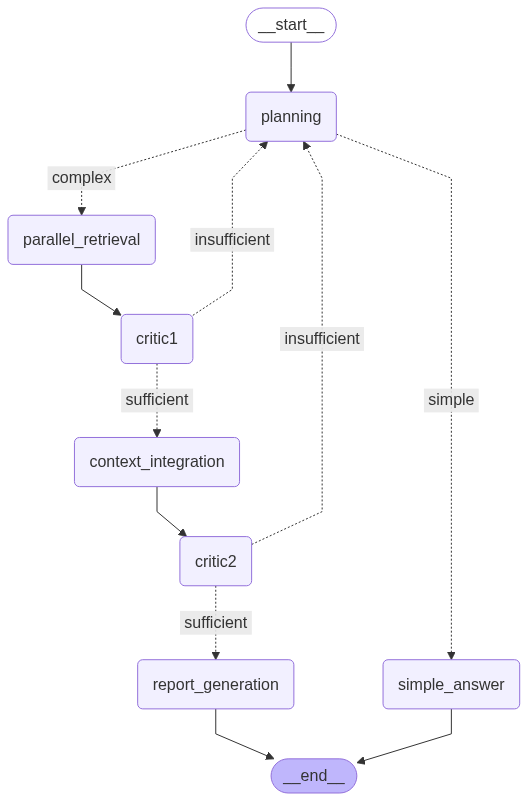

In [108]:
workflow_instance = RAGWorkflow()
app = workflow_instance._create_workflow()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## RAG System Workflow Diagram (Graphviz)

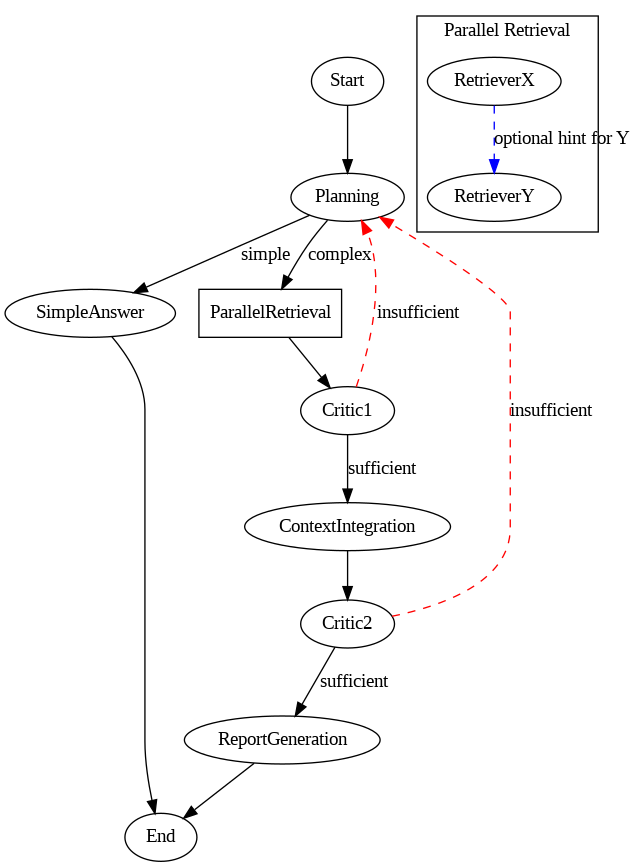

In [66]:
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph('RAG_Workflow', filename='rag_workflow', format='png')

# Main Node
dot.node('Start', shape='ellipse')
dot.node('Planning')
dot.node('SimpleAnswer')
dot.node('ParallelRetrieval', shape='box')
dot.node('Critic1')
dot.node('ContextIntegration')
dot.node('Critic2')
dot.node('ReportGeneration')
dot.node('End', shape='ellipse')

# Main Edge
dot.edge('Start', 'Planning')
dot.edge('Planning', 'SimpleAnswer', label='simple')
dot.edge('Planning', 'ParallelRetrieval', label='complex')
dot.edge('SimpleAnswer', 'End')
dot.edge('ParallelRetrieval', 'Critic1')

dot.edge('Critic1', 'Planning', label='insufficient', color='red', style='dashed')
dot.edge('Critic1', 'ContextIntegration', label='sufficient')
dot.edge('ContextIntegration', 'Critic2')
dot.edge('Critic2', 'Planning', label='insufficient', color='red', style='dashed')
dot.edge('Critic2', 'ReportGeneration', label='sufficient')
dot.edge('ReportGeneration', 'End')

# Parallel Retrieval 내부 서브그래프 (피드백 채널 제거)
with dot.subgraph(name='cluster_parallel') as c:
    c.attr(label='Parallel Retrieval')

    c.node('RetrieverX')
    c.node('RetrieverY')

    # 검색 흐름: RetrieverX와 RetrieverY가 병렬로 작동하며,
    # Y가 X의 힌트를 활용할 수 있는 개념적인 흐름만 남김.
    c.edge('RetrieverX', 'RetrieverY', label='optional hint for Y', color='blue', style='dashed') # Y가 X의 힌트를 활용할 수 있음을 나타냄

# 출력 랜더링
dot.render('rag_workflow', format='png')

display(Image(filename='rag_workflow.png'))

# 변경 사항
* ReAct 적용
* ReAct 프롬프트 적용
* Tavily -> Google serper 변경
    * 사유: Tavily 무료 용량 다씀, Google serper의 검색 결과가 더욱 퀄리티가 좋음
* Planning Agent의 역할 축소(단순 복잡도 구분 역할) : 쿼리 decompose가 필요할 수도 있긴 함


# 수정(테스트) 예정 사항
* 에이전트 추론 및 계획 능력 고도화
 * Tree-of-Thought (ToT)를 PlanningAgent에 적용
* 안정성 및 효율성 확보 (에러 핸들링 및 최적화)
 * ReAct 에이전트의 예외 처리 강화
 * LLM 모델 최적화(비용 및 속도)
* 사용자 경험 향상 (답변 품질 극대화)
 * Self-Consistency를 ReportGeneratorAgent에 적용